<a href="https://colab.research.google.com/github/cc-ats/mlp_tutorial/blob/main/Lesson7_BP-GPR_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 7: Behler-Parrinello Gaussian Process Regression (BP-GPR) for Machine Learning Potentials


$\Delta$MLP with PyTorch for the Claisen Rearrangement reaction

For this tutorial, we will be combining the Gaussian Process Regression (GPR) from Lesson 2 and the symmetry functions from the Behler-Parrinello and ANI models from Lesson 4 to train a $\Delta$ Machine Learning Potential ($\Delta$MLP) model to reproduce the energy and forces for the Claisen Rearrangement reaction. With a BP-GPR, we can use the BP symmetry functions for feature extraction and the GPR kernel for predicting observables. The goal of this model is to train with data that is from semiempirical (PM3) and DFT (B3LYP) levels of theory. The BP-GPR model will be used to correct the semiempirical values to obtain DFT level accuracy, that makes it a $\Delta$MLP model.

## Importing PyTorch Lightning and Libraries

We will first install PyTorch Lightning and import libraries needed to train our machine learning models

In [1]:
%%capture
!pip install pytorch-lightning > /dev/null
!pip install gpytorch > /dev/null

import math
from typing import Sequence, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import gpytorch

from torch.utils.data import TensorDataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers

## Defining Symmetry Functions

Now we will define the radial symmetry functions:

pairwise_vector: Distance function for calculating distances between each atom.

symmetry_function_g1: BP radial symmetry function.

symmetry_function_g2: BP angular symmetry function.

symmetry_function_g2ani: ANI angular symmetry function

In [2]:
def pairwise_vector(coords: Tensor) -> Tensor:
    num_batches, num_channels, _ = coords.size()
    rij = coords[:, :, None] - coords[:, None]
    mask = ~torch.eye(num_channels, dtype=torch.bool, device=coords.device) # remove self-interaction
    rij = torch.masked_select(rij, mask.unsqueeze(2)).view(num_batches, num_channels, num_channels - 1, 3)
    return rij

def symmetry_function_g1(rij: Tensor, Rcr: float, EtaR: Tensor, ShfR: Tensor) -> Tensor:
    dij = torch.norm(rij, dim=3)
    fij = (torch.cos(dij / Rcr * math.pi) + 1) * 0.5 * (dij <= Rcr)
    g1 = torch.sum(torch.exp(-EtaR.unsqueeze(dim=2) * (dij.unsqueeze(dim=-1) - ShfR.unsqueeze(dim=2))**2) * fij.unsqueeze(dim=-1), dim=2)
    return g1

def symmetry_function_g2(rij: Tensor, Rca: float, Zeta: Tensor, EtaA: Tensor, LamA: Tensor) -> Tensor:
    c = torch.combinations(torch.arange(rij.size(2)), r=2)
    #print(c)
    rij = rij[:, :, c]
    r12 = rij[:, :, :, 0]
    r13 = rij[:, :, :, 1]
    r23 = r12 - r13
    d12 = torch.norm(r12, dim=3)
    d13 = torch.norm(r13, dim=3)
    d23 = torch.norm(r23, dim=3)
    f12 = (torch.cos(d12 / Rca * math.pi) + 1) * 0.5
    f13 = (torch.cos(d13 / Rca * math.pi) + 1) * 0.5
    f23 = (torch.cos(d23 / Rca * math.pi) + 1) * 0.5
    cosine = torch.einsum('ijkl,ijkl->ijk', r12, r13) / (d12 * d13)

    g2 = torch.sum(2**(1 - Zeta.unsqueeze(dim=2)) * (1 + LamA.unsqueeze(dim=2) * cosine.unsqueeze(dim=-1))**Zeta.unsqueeze(dim=2) * torch.exp(-EtaA.unsqueeze(dim=2) * (d12**2 + d13**2 + d23**2).unsqueeze(dim=-1)) * (f12 * f13 * f23).unsqueeze(dim=-1), dim=2)
    return g2

def symmetry_function_g2ani(rij: Tensor, Rca: float, Zeta: Tensor, ShfZ: Tensor, EtaA: Tensor, ShfA: Tensor) -> Tensor:
    c = torch.combinations(torch.arange(rij.size(2)), r=2)
    rij = rij[:, :, c]
    r12 = rij[:, :, :, 0]
    r13 = rij[:, :, :, 1]

    r23 = r12 - r13
    d12 = torch.norm(r12, dim=3)
    d13 = torch.norm(r13, dim=3)
    f12 = (torch.cos(d12 / Rca * math.pi) + 1) * 0.5
    f13 = (torch.cos(d13 / Rca * math.pi) + 1) * 0.5
    cosine = torch.einsum('ijkl,ijkl->ijk', r12, r13) / (d12 * d13)
    cosine = torch.cos(torch.acos(cosine).unsqueeze(dim=-1) - ShfA.unsqueeze(dim=2))
    g2 = torch.sum(2**(1 - Zeta.unsqueeze(dim=2)) * (1 + cosine)**Zeta.unsqueeze(dim=2) * torch.exp(-EtaA.unsqueeze(dim=2) * (0.5 * (d12 + d13).unsqueeze(dim=-1) - ShfZ.unsqueeze(dim=2))**2) * (f12 * f13).unsqueeze(dim=-1), dim=2)
    return g2

## Defining Feature Extraction Classes

### Defining the BP Feature Class

Now we will create the feature class, which takes input information and uses functions to extract characteristics unique to the called input features. Here we will be using the previously defined symmetry functions for feature extraction.

In [3]:
class Feature(nn.Module):
    def __init__(self, Rcr: float, EtaR: Tensor, ShfR: Tensor, Rca: float, Zeta: Tensor, EtaA: Tensor, LamA: Tensor) -> None:
        super().__init__()
        assert len(EtaR) == len(ShfR) == len(LamA)
        assert len(Zeta) == len(EtaA)
        self.Rcr = Rcr
        self.Rca = Rca
        self.EtaR = torch.Tensor(EtaR)
        self.ShfR = torch.Tensor(ShfR)
        self.Zeta = torch.Tensor(Zeta)
        self.EtaA = torch.Tensor(EtaA)
        self.LamA = torch.Tensor(LamA)

    def forward(self, coords: Tensor, atom_types: Tensor) -> Tensor:
        num_batches, num_channels, _ = coords.size()
        rij = pairwise_vector(coords)
        EtaR = self.EtaR.to(device=coords.device)[atom_types]
        ShfR = self.ShfR.to(device=coords.device)[atom_types]
        Zeta = self.Zeta.to(device=coords.device)[atom_types]
        EtaA = self.EtaA.to(device=coords.device)[atom_types]
        LamA = self.LamA.to(device=coords.device)[atom_types]
        g1 = symmetry_function_g1(rij, self.Rcr, EtaR, ShfR)
        g2 = symmetry_function_g2(rij, self.Rca, Zeta, EtaA, LamA)

        return torch.concat((g1, g2), dim=2)

    @property
    def output_length(self) -> int:
        return len(self.EtaR[0]) + len(self.EtaA[0])

### Defining the ANI Feature Class

We will create a similar feature class for ANI that uses the ANI angle symmetry function.


In [4]:
class FeatureANI(nn.Module):
    def __init__(self, Rcr: float, EtaR: Tensor, ShfR: Tensor, Rca: float, Zeta: Tensor, ShfZ: Tensor, EtaA: Tensor, ShfA: Tensor) -> None:
        super().__init__()
        assert len(EtaR) == len(ShfR)
        assert len(Zeta) == len(ShfZ) == len(EtaA) == len(ShfA)
        self.Rcr = Rcr
        self.Rca = Rca
        self.EtaR = torch.Tensor(EtaR)
        self.ShfR = torch.Tensor(ShfR)
        self.Zeta = torch.Tensor(Zeta)
        self.ShfZ = torch.Tensor(ShfZ)
        self.EtaA = torch.Tensor(EtaA)
        self.ShfA = torch.Tensor(ShfA)

    def forward(self, coords: Tensor, atom_types: Tensor) -> Tensor:
        num_batches, num_channels, _ = coords.size()
        rij = pairwise_vector(coords)
        EtaR = self.EtaR.to(device=coords.device)[atom_types]
        ShfR = self.ShfR.to(device=coords.device)[atom_types]
        Zeta = self.Zeta.to(device=coords.device)[atom_types]
        ShfZ = self.ShfZ.to(device=coords.device)[atom_types]
        EtaA = self.EtaA.to(device=coords.device)[atom_types]
        ShfA = self.ShfA.to(device=coords.device)[atom_types]
        g1 = symmetry_function_g1(rij, self.Rcr, EtaR, ShfR)
        g2 = symmetry_function_g2ani(rij, self.Rca, Zeta, ShfZ, EtaA, ShfA)

        return torch.concat((g1, g2), dim=2)

    @property
    def output_length(self) -> int:
        return len(self.EtaR[0]) + len(self.EtaA[0])

## Creating the BP-GPR Model


### Defining the BP-GPR Class

This class will combine the symmetry functions with the GPR model.

In [5]:
class BPGPR(gpytorch.models.ExactGP):
    def __init__(self, descriptor: Tensor, Y: Tensor, likelihood, learning_rate=5e-4) -> None:
        shape = descriptor.shape
        X = descriptor #.reshape(shape[0], shape[1]*shape[2])
        super(BPGPR, self).__init__(X, Y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Importing Data and Seeding

We will now import our semiempirical and DFT calculation data.

In [6]:
import numpy as np

ds = np.DataSource(None)

qm_coord = np.array(np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/qm_coord.npy", "rb")), dtype="float32")
atom_types = np.loadtxt(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/qm_elem.txt", "r"), dtype=int)

elems = np.unique(atom_types).tolist()
atom_types = np.array([[elems.index(i) for i in atom_types]])
atom_types = atom_types.repeat(len(qm_coord), axis=0)

energy = np.array((np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/energy.npy", "rb")) - np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/energy_sqm.npy", "rb"))) * 27.2114 * 23.061, dtype="float32")
energy = energy - energy.mean()
qm_gradient = np.array((np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/qm_grad.npy", "rb")) - np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/qm_grad_sqm.npy", "rb"))) * 27.2114 * 23.061 / 0.529177249, dtype="float32")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

qm_coord = torch.from_numpy(qm_coord).to(device)
atom_types = torch.from_numpy(atom_types).to(device)
energy = torch.from_numpy(energy).to(device)
qm_gradient = torch.from_numpy(qm_gradient).to(device)

## Using ANI for Feature Extraction

The ANI model is set to be used and the ANI parameters are defined.


In [7]:
ani = True

if ani:
  # From TorchANI
  Rcr = 5.2000e+00
  Rca = 3.5000e+00
  EtaR = [1.6000000e+01]
  ShfR = [9.0000000e-01,1.1687500e+00,1.4375000e+00,1.7062500e+00,1.9750000e+00,2.2437500e+00,2.5125000e+00,2.7812500e+00,3.0500000e+00,3.3187500e+00,3.5875000e+00,3.8562500e+00,4.1250000e+00,4.3937500e+00,4.6625000e+00,4.9312500e+00]
  Zeta = [3.2000000e+01]
  ShfZ = [1.9634954e-01,5.8904862e-01,9.8174770e-01,1.3744468e+00,1.7671459e+00,2.1598449e+00,2.5525440e+00,2.9452431e+00]
  EtaA = [8.0000000e+00]
  ShfA = [9.0000000e-01,1.5500000e+00,2.2000000e+00,2.8500000e+00]
  EtaR, ShfR = np.array(np.meshgrid(EtaR, ShfR)).reshape(2, -1)
  Zeta, ShfZ, EtaA, ShfA = np.array(np.meshgrid(Zeta, ShfZ, EtaA, ShfA)).reshape(4, -1)
  EtaR = np.repeat([EtaR], 3, axis=0)
  ShfR = np.repeat([ShfR], 3, axis=0)
  Zeta = np.repeat([Zeta], 3, axis=0)
  ShfZ = np.repeat([ShfZ], 3, axis=0)
  EtaA = np.repeat([EtaA], 3, axis=0)
  ShfA = np.repeat([ShfA], 3, axis=0)
  descriptor = FeatureANI(Rcr, EtaR, ShfR, Rca, Zeta, ShfZ, EtaA, ShfA)
else:
  Rcr = 6.0
  Rca = 6.0
  ShfR = np.zeros((3,6)) # H, C, O
  EtaR = [0.0, 0.04, 0.14, 0.32, 0.71, 1.79]
  EtaR = np.repeat([EtaR], 3, axis=0) # H, C, O
  Zeta = [1, 2, 4, 8, 16, 32, 1, 2, 4, 8, 16, 32]
  Zeta = np.repeat([Zeta], 3, axis=0) # H, C, O
  EtaA = [0.0, 0.04, 0.14, 0.32, 0.71, 1.79, 0.0, 0.04, 0.14, 0.32, 0.71, 1.79]
  EtaA = np.repeat([EtaA], 3, axis=0) # H, C, O
  LamA = [1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1]
  LamA = np.repeat([LamA], 3, axis=0) # H, C, O
  descriptor = Feature(Rcr, EtaR, ShfR, Rca, Zeta, EtaA, LamA)

## GPR Hyperparameters

### Reshaping and Initializing

The atom types and coordinates are reshaped with the energies for use in the regression kernel. Then the marginal likelihood function is initialized.

In [8]:
nskip = 1

# Reshape Matrix inputs to vector
X = descriptor.forward(qm_coord, atom_types)[::nskip,:,:]
shape = X.shape
X  = X.reshape(shape[0], shape[1]*shape[2])
Y = energy[::nskip]

# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = BPGPR(X, Y, likelihood)

### Training the GPR Hyperparameters

Now we can begin training to optimize the GPR hyperparameters.

In [9]:
training_iter = 500

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(X)
    # Calc loss and backprop gradients
    loss = -mll(output, Y)
    loss.backward()
    if (i+1) % 100 == 0:
      print('Iter %d/%d - Loss: %.3f   outputscale: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.outputscale.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

# Print Trained hyperparameters
print('outputscale: ', model.covar_module.outputscale.item())
print('lengthscale: ', model.covar_module.outputscale.item())
print('noise: ', model.likelihood.noise.item())

Iter 100/500 - Loss: 1.700   outputscale: 2.948   lengthscale: 3.301   noise: 0.851
Iter 200/500 - Loss: 1.516   outputscale: 4.564   lengthscale: 3.560   noise: 0.192
Iter 300/500 - Loss: 1.460   outputscale: 5.940   lengthscale: 3.748   noise: 0.074
Iter 400/500 - Loss: 1.400   outputscale: 7.171   lengthscale: 3.976   noise: 0.033
Iter 500/500 - Loss: 1.394   outputscale: 8.245   lengthscale: 4.165   noise: 0.018
outputscale:  8.256046295166016
lengthscale:  8.256046295166016
noise:  0.01762973517179489


## Evaluating the Model's Accuracy

### Evaluation of the Predicted Energy (RMSE)
We will now calculate the RMSE for the energy and forces predicted by the BP-GPR mode

In [10]:
model.eval()
likelihood.eval()

# Prepare testing set
qm_coord = torch.autograd.Variable(qm_coord, requires_grad=True)
X_test = descriptor.forward(qm_coord, atom_types)
shape = X_test.shape
X_test = X_test.reshape(shape[0], shape[1]*shape[2])

# Make predictions
y_preds = likelihood(model(X_test))

y_mean = y_preds.mean
y_var = y_preds.variance
y_covar = y_preds.covariance_matrix

def eval(ref, pred):
    rmse = torch.sqrt(torch.mean((ref-pred)**2))
    q2 = 1 - torch.sum((ref-pred)**2)/torch.sum((ref-torch.mean(ref))**2)
    return rmse, q2

print(torch.mean(y_var))
# Evaluate performance on energy predictions
y_rmse, y_q2 = eval(energy ,y_mean)
print("Energy Prediction RMSE: ", y_rmse.item(),"Q^2: ", y_q2.item())

/usr/local/lib/python3.10/dist-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


tensor(0.0675, grad_fn=<MeanBackward0>)
Energy Prediction RMSE:  0.050121136009693146 Q^2:  0.9998199343681335


### Evaluation of the Predicted Forces (RMSE)

In [11]:
auto_grad, = torch.autograd.grad(y_mean.sum(), [qm_coord])
rmse = torch.sqrt(torch.mean((auto_grad - qm_gradient)**2))
q2 = 1 - torch.sum((qm_gradient-auto_grad)**2)/torch.sum((qm_gradient-torch.mean(qm_gradient))**2)
print("Force RMSE: ", rmse.item(), "Q^2", q2.item())

Force RMSE:  4.071394920349121 Q^2 0.8092787265777588


### Plotting RMSD for the BP-GPR Model

Here we plot the RMSD for the predicted and reference energy and forces for the BP-GPR model.

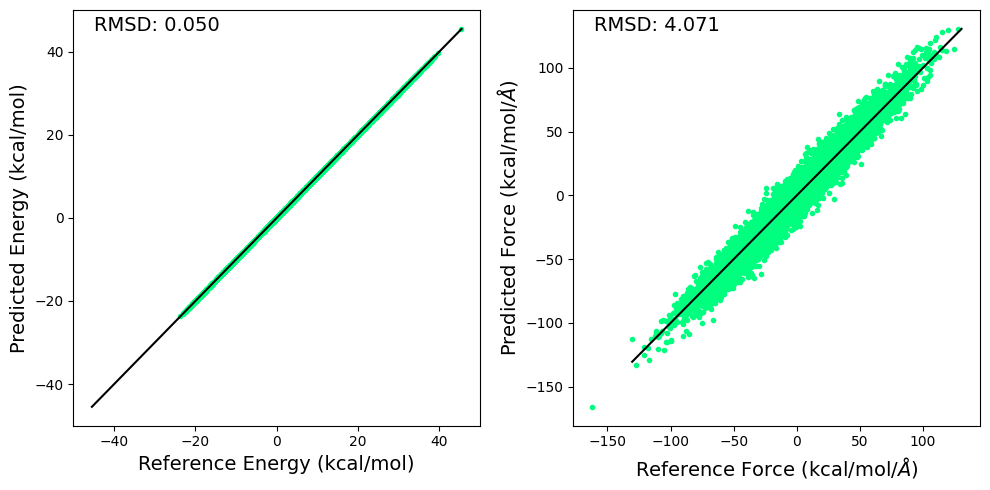

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(10,5))

e1 = energy.cpu().detach().numpy() + np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/energy_sqm.npy","rb")) * 27.2114 * 23.061
e2 = y_mean.cpu().detach().numpy() + np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/energy_sqm.npy","rb")) * 27.2114 * 23.061
ax[0].plot(e1, e2, linestyle='none', marker='.', color='springgreen')
ax[0].plot([np.max(np.concatenate((e1,e2))), -np.max(np.concatenate((e1,e2)))], [np.max(np.concatenate((e1,e2))), -np.max(np.concatenate((e1,e2)))], color="k", linewidth=1.5)
ax[0].set_xlabel("Reference Energy (kcal/mol)", size=14)
ax[0].set_ylabel("Predicted Energy (kcal/mol)", size=14)
ax[0].annotate('RMSD: %.3f' % np.sqrt(np.mean((e1 - e2)**2)), xy=(0.05, 0.95), xycoords='axes fraction', size=14)

f1 = -qm_gradient.cpu().detach().numpy().reshape(-1) - np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/qm_grad_sqm.npy","rb")).reshape(-1) * 27.2114 * 23.061 / 0.529177249
f2 = -auto_grad.cpu().detach().numpy().reshape(-1) - np.load(ds.open("https://github.com/cc-ats/mlp_tutorial/raw/main/Claisen_Rearrangement/qm_grad_sqm.npy","rb")).reshape(-1) * 27.2114 * 23.061 / 0.529177249

ax[1].plot(f1, f2, linestyle='none', marker='.', color='springgreen')
plt.plot([-np.abs(np.max(np.concatenate((f1,f2)))), np.max(np.concatenate((f1,f2)))], [-np.max(np.concatenate((f1,f2))), np.max(np.concatenate((f1,f2)))], color="k", linewidth=1.5)
ax[1].set_xlabel(r"Reference Force (kcal/mol/$\AA$)", size=14)
ax[1].set_ylabel(r"Predicted Force (kcal/mol/$\AA$)", size=14)
ax[1].annotate('RMSD: %.3f' % np.sqrt(np.mean((f1 - f2)**2)), xy=(0.05, 0.95), xycoords='axes fraction', size=14)

plt.tight_layout()
plt.savefig('rmsd.png', dpi=300)

### Tabulating the RMSE for the BP-GPR Model

Finally, we can tabulate the RMSE for the BP-GPR model.

In [13]:
qm_coord_train = torch.autograd.Variable(qm_coord[::nskip,:,:], requires_grad=True)
X_train = descriptor.forward(qm_coord_train, atom_types[::nskip,:])
shape = X_train.shape
X_train = X_train.reshape(shape[0], shape[1]*shape[2])

# Make predictions
y_preds = likelihood(model(X_train))

y_mean = y_preds.mean
y_var = y_preds.variance
y_covar = y_preds.covariance_matrix

def eval(ref, pred):
    rmse = torch.sqrt(torch.mean((ref-pred)**2))
    q2 = 1 - torch.sum((ref-pred)**2)/torch.sum((ref-torch.mean(ref))**2)
    return rmse, q2

# Evaluate performance on energy predictions
y_rmse, y_q2 = eval(Y ,y_mean)
print(f'Energy Prediction RMSE: {y_rmse.item():6>.4f}\t Q^2: {y_q2.item():6>.4f}')


# Evaluate Forces
auto_grad, = torch.autograd.grad(y_mean.sum(), [qm_coord_train])
rmse = torch.sqrt(torch.mean((auto_grad - qm_gradient[::nskip,:,:])**2))
q2 = 1 - torch.sum((qm_gradient[::nskip,:,:]-auto_grad)**2)/torch.sum((qm_gradient[::nskip,:,:]-torch.mean(qm_gradient[::nskip,:,:]))**2)
print(f'Force Prediction  RMSE: {rmse.item():6>.4f}\t Q^2: {q2.item():6>.4f}')

Energy Prediction RMSE: 0.0501	 Q^2: 0.9998
Force Prediction  RMSE: 4.0714	 Q^2: 0.8093
